In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re

In [32]:
pd.set_option('display.max_columns', None)

In [33]:
seed = 538

In [34]:
WORKING_DIRECTORY = 'D:/Fire Project/data/'

## Incident counts, weighted by population

We'll start by downloading the total 2020 population counts for US incorporated places and minor encorporated places: April 1 2020 to July 1 2021 from [the Census.gov website](https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-cities-and-towns.html). [Direct link.](https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/cities/totals/sub-est2021_all.csv)

In [68]:
conn = sqlite3.Connection(WORKING_DIRECTORY + 'fire_data.db')

In [18]:
total_inc_counts = pd.read_sql("""
    SELECT ia.CITY || ',' || ia.STATE 
                AS CITYSTATE, 
            COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE
""", conn)

In [69]:
total_inc_pop = total_inc_counts.merge(pops, 
                                       how='inner', 
                                       on='CITYSTATE')

In [79]:
total_inc_pop = total_inc_pop.loc[:, ['CITYSTATE', 'INC_COUNT', 'ESTIMATESBASE2020']] \
                                .groupby(by='CITYSTATE') \
                                .max()

In [80]:
total_inc_pop['INC_COUNT_ADJ'] = total_inc_pop.INC_COUNT / total_inc_pop.ESTIMATESBASE2020

In [81]:
total_inc_pop.to_csv(path_or_buf=WORKING_DIRECTORY + 'total_inc_pop_pre2019.csv',
                     sep=',',
                     index=False)

# Incident counts by incident type (population adjusted)

In [23]:
inc_type_counts = pd.read_sql("""
    SELECT ia.CITY || ',' || ia.STATE 
                AS CITYSTATE, 
            bi.INC_TYPE 
                AS INC_TYPE,
            COUNT(bi.ID) 
                AS INC_COUNT
    FROM basic_incident bi JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200 
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE, bi.INC_TYPE
""", conn)

In [51]:
pops[pops.CITYSTATE == 'KANSAS CITY,KS']

,PLACE,NAME,STNAME,ESTIMATESBASE2020,CITYSTATE
21566,36000,KANSAS CITY,KS,156602,"KANSAS CITY,KS"


In [24]:
inc_type_pop = inc_type_counts.merge(pops, 
                                       how='inner', 
                                       on='CITYSTATE')

Let's look at the most common incident types in our dataset.

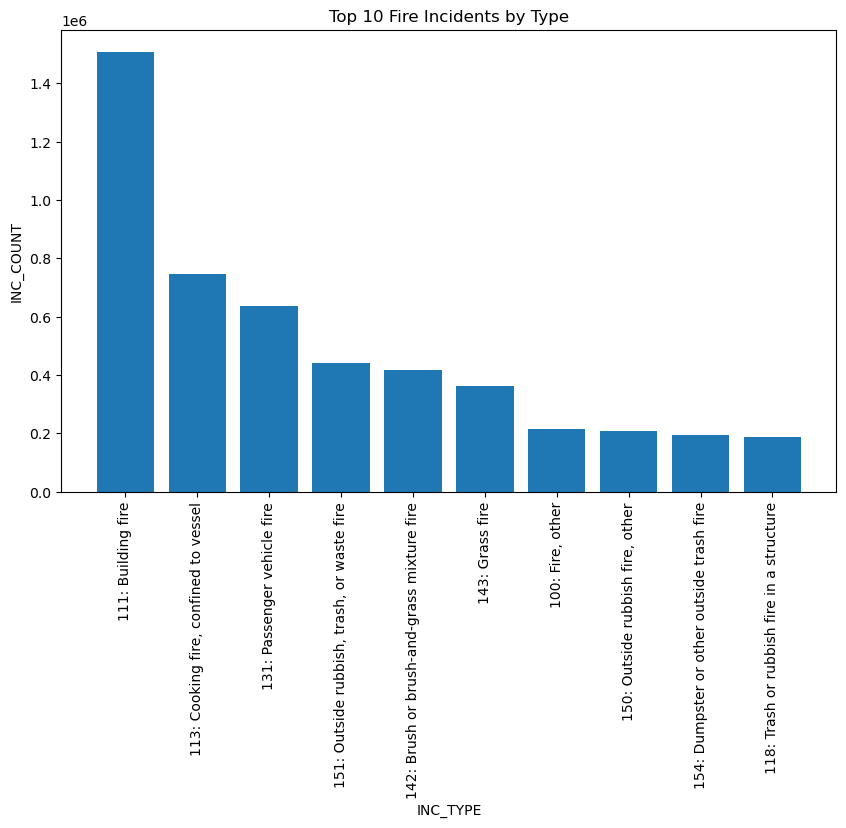

In [25]:
grouped_data = inc_type_pop.groupby('INC_TYPE')['INC_COUNT'].sum().reset_index()

sorted_data = grouped_data.sort_values('INC_COUNT', ascending=False)

# Get top 10 incident types
top_10_data = sorted_data.head(10).copy()  # Create a copy of the data to avoid warnings

inc_type_descriptions = {
    111: 'Building fire',
    113: 'Cooking fire, confined to vessel',
    131: 'Passenger vehicle fire',
    151: 'Outside rubbish, trash, or waste fire',
    142: 'Brush or brush-and-grass mixture fire',
    143: 'Grass fire',
    150: 'Outside rubbish fire, other',
    100: 'Fire, other',
    118: 'Trash or rubbish fire in a structure',
    154: 'Dumpster or other outside trash fire',
}

top_10_data.loc[:, 'INC_TYPE_DESC'] = top_10_data['INC_TYPE'].map(inc_type_descriptions)

top_10_data.loc[:, 'INC_TYPE_WITH_DESC'] = top_10_data['INC_TYPE'].astype(str) + ': ' + top_10_data['INC_TYPE_DESC']

plt.figure(figsize=(10, 6))
plt.bar(top_10_data['INC_TYPE_WITH_DESC'], top_10_data['INC_COUNT'])
plt.xlabel('INC_TYPE')
plt.ylabel('INC_COUNT')
plt.title('Top 10 Fire Incidents by Type')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


In [26]:
inc_type_pop111 = inc_type_pop[inc_type_pop.INC_TYPE == 111].copy()
inc_type_pop111.loc[:, '111_COUNT_ADJ'] = inc_type_pop111.INC_COUNT / inc_type_pop111.ESTIMATESBASE2020

In [27]:
inc_type_pop113 = inc_type_pop[inc_type_pop.INC_TYPE == 113].copy()
inc_type_pop113.loc[:, '113_COUNT_ADJ'] = inc_type_pop113.INC_COUNT / inc_type_pop113.ESTIMATESBASE2020

In [28]:
inc_type_pop111.to_csv(path_or_buf=WORKING_DIRECTORY + 'inc_type_pop111_pre2019.csv',
                     sep=',',
                     index=False)

inc_type_pop113.to_csv(path_or_buf=WORKING_DIRECTORY + 'inc_type_pop113_pre2019.csv',
                     sep=',',
                     index=False)

### Check why some states are getting dropped when merging pop_counts and total_inc_counts

### Total incident count by year and city, adjusted for population